# Bank Term Deposit Prediction Model
### Exploratory Data Analysis on bank term deposit subscription dataset.

Bank has multiple banking products that it sells to customer such as saving account, credit cards, investments like Term Deposit, Recurring Deposit etc. The investment department of the Bank would want to be able to identify their customers who potentially would subscribe to their term deposits. Once it can predict the chances that customer will purchase a product, the marketing managers can carefully tune their directed campaigns to these customer to improve the Bank performance. 

We will do  data cleaning, data exploration,dealing with class imbalance and then figure out a robust machine learning algorithm for predicting the potential customers who would subscribe to the term deposit using different Machine learning library. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
df= pd.read_csv("Bank_TD_Data.csv")
df.head()

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,999.0,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1002,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no


### I . Data Preparation and Cleaning:

#### Attribute Information:

Input Variables

#Client Data
- Id - Id variable
- Age - Age of client 
- Job - Job of the client
- marital - marital status of the client (note "divorced" means "divorced or widowed")
- education - education of the client
- default - has credit in default (binary "yes" or "no")
- balance- average yearly balance inn euros 
- housing - has housing loan (binary "yes" or "no")
- loan - has personal loan (binary "yes" or "no")

#related with last contact of current campaign
- contact - contact communication type
- day - last contact day of the month
- month - last contact month of the year
- duration - last contact duration in seconds 

#other attributes
- campaign - number of contacts performed during this campaign and for this client (includes last contact)
- pdays - no. of days that passed by after the client was last contacted from a previous campaign (-1 means client was not contacted previously)
- previous - no. of contacts performed during this campaign and for this client 
- poutcome - outcome of the previous marketing campaign

Output Variable

- y - has the client subscribed a term deposit? (binary "yes" or "no")


In [3]:
row, col = df.shape

print(f"The Bank Term Deposit Prediction dataset includes {col} attributes of {row} customers")

The Bank Term Deposit Prediction dataset includes 18 attributes of 45211 customers


#### Datatype of Attributes

In [4]:
df.dtypes

Id             int64
age          float64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day            int64
month         object
duration       int64
campaign       int64
pdays          int64
previous       int64
poutcome      object
y             object
dtype: object

#### Check for duplicate rows

In [5]:
duplicated = df.duplicated().sum()

if duplicated:
    print(f"Duplicate rows in the dataset are {duplicated}")
else:
    print("There are no duplicate values in the dataset")

There are no duplicate values in the dataset


#### Handling Incorrect data

The datatype of age is float so lets check if there are any non integer values in dataset

In [6]:
df[~df['age'].apply(lambda x:x.is_integer())]

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
7,1008,NaN,entrepreneur,divorced,tertiary,yes,NaN,yes,no,unknown,5,may,380,1,-1,0,unknown,no
53,1054,NaN,admin.,single,secondary,no,-76.0,yes,no,unknown,5,may,787,1,-1,0,unknown,no
54,1055,NaN,technician,single,secondary,no,-103.0,yes,yes,unknown,5,may,145,1,-1,0,unknown,no
55,1056,NaN,entrepreneur,single,tertiary,no,243.0,no,yes,unknown,5,may,174,1,-1,0,unknown,no
56,1057,NaN,management,single,tertiary,no,424.0,yes,no,unknown,5,may,104,1,-1,0,unknown,no
57,1058,NaN,blue-collar,married,unknown,no,306.0,yes,no,unknown,5,may,13,1,-1,0,unknown,no
58,1059,NaN,blue-collar,single,unknown,no,24.0,yes,no,unknown,5,may,185,1,-1,0,unknown,no
59,1060,NaN,services,married,primary,no,179.0,yes,no,unknown,5,may,1778,1,-1,0,unknown,no
60,1061,NaN,admin.,married,tertiary,no,0.0,yes,no,unknown,5,may,138,1,-1,0,unknown,no


There aren't any non integer values in the dataset. But we can observe unusal values for age like 999. So let's find out the abnormal age values in the dataset.

In [7]:
df[(df['age']>100) | (df['age']<1)]

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,999.0,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
45203,46204,-1.0,student,single,tertiary,no,113.0,no,no,cellular,17,nov,266,1,-1,0,unknown,yes
45204,46205,-1.0,retired,married,secondary,no,2850.0,no,no,cellular,17,nov,300,1,40,8,failure,yes
45205,46206,-1.0,technician,single,secondary,no,505.0,no,yes,cellular,17,nov,386,2,-1,0,unknown,yes


In [8]:
df.loc[((df['age']>100) | (df['age']<1)), 'age'] = np.nan

In [9]:
df[~df['age'].apply(lambda x:x.is_integer())]

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,NaN,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
7,1008,NaN,entrepreneur,divorced,tertiary,yes,NaN,yes,no,unknown,5,may,380,1,-1,0,unknown,no
53,1054,NaN,admin.,single,secondary,no,-76.0,yes,no,unknown,5,may,787,1,-1,0,unknown,no
54,1055,NaN,technician,single,secondary,no,-103.0,yes,yes,unknown,5,may,145,1,-1,0,unknown,no
55,1056,NaN,entrepreneur,single,tertiary,no,243.0,no,yes,unknown,5,may,174,1,-1,0,unknown,no
56,1057,NaN,management,single,tertiary,no,424.0,yes,no,unknown,5,may,104,1,-1,0,unknown,no
57,1058,NaN,blue-collar,married,unknown,no,306.0,yes,no,unknown,5,may,13,1,-1,0,unknown,no
58,1059,NaN,blue-collar,single,unknown,no,24.0,yes,no,unknown,5,may,185,1,-1,0,unknown,no
59,1060,NaN,services,married,primary,no,179.0,yes,no,unknown,5,may,1778,1,-1,0,unknown,no
60,1061,NaN,admin.,married,tertiary,no,0.0,yes,no,unknown,5,may,138,1,-1,0,unknown,no


#### Renaming columns in dataframe

In [10]:
# Before renaming the columns
print(df.columns)
   
df.rename(columns = {'y':'subscribed_td'}, inplace = True)
   
# After renaming the columns
print(df.columns)

Index(['Id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')
Index(['Id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'subscribed_td'],
      dtype='object')


#### More structure to data

In [11]:
df.job.value_counts().to_frame()

,job
blue-collar,9732
management,9458
technician,7597
admin.,5171
services,4154
retired,2264
self-employed,1579
entrepreneur,1487
unemployed,1303
housemaid,1240


In [12]:
df['job'].replace({'entrepreneur': 'self-employed', 'technician': 'blue-collar',
                   'admin.': 'white-collar', 'management': 'white-collar',
                  'services': 'pink-collar', 'housemaid': 'pink-collar'}, inplace=True)

In [13]:
df.job.value_counts().to_frame()

,job
blue-collar,17329
white-collar,14629
pink-collar,5394
self-employed,3066
retired,2264
unemployed,1303
student,938
unknown,288


#### Missing values

It is good to start by checking missing values and fixing it. Let us find out if this dataset has any missing values.

In [14]:
df.shape

(45211, 18)

In [15]:
df.isnull().sum()

Id                0
age              13
job               0
marital           0
education         0
default           0
balance           3
housing           0
loan              0
contact           0
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
subscribed_td     0
dtype: int64

In [16]:
#Let's drop these null values
df.dropna(inplace=True)
df.shape

(45196, 18)

## II. Data Exploration

In [17]:
df.head()

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed_td
1,1002,44.0,blue-collar,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,33.0,self-employed,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,1006,35.0,white-collar,married,tertiary,no,231.0,yes,no,unknown,5,may,139,1,-1,0,unknown,no


#### Statistics Summary

In [18]:
df.describe()

,Id,age,balance,day,duration,campaign,pdays,previous
count,45196.000000,45196.000000,45196.000000,45196.000000,45196.000000,45196.000000,45196.000000,45196.000000
mean,23610.491260,40.935879,1362.562129,15.809209,258.137645,2.764404,40.210594,0.580339
std,13047.121994,10.617774,3045.192527,8.321988,257.448929,3.098377,100.142735,2.303536
min,1002.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,12311.750000,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,23610.500000,39.000000,449.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,34909.250000,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,46211.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Age of customers

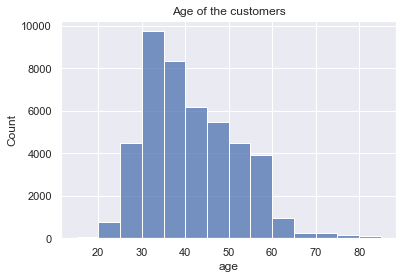

In [19]:
import numpy as np
sns.set_theme(style="darkgrid")
ax = sns.histplot(x="age", data=df, bins=np.arange(15, 90, 5))
ax.set_title('Age of the customers');

The age of the patients range from 20 yrs to 90 yrs out of which patients in the age group of 25 to 50 yrs seem more.

In [20]:
# Printing values in each age range bin

age_range=df['age'].value_counts(bins=np.arange(15, 85, 10)).to_frame().reset_index()
age_range.rename(columns = {'index':"age_range(from,to)",'age':'customer_count'}, inplace = True)
age_range.set_index('age_range(from,to)')

print("\n")
print("\033[1m" +"Customers in each age range (Max to min)"+ "\033[0m") # to print in bold
age_range



Customers in each age range (Max to min)


,"age_range(from,to)",customer_count
0,"(25.0, 35.0]",15570
1,"(35.0, 45.0]",13850
2,"(45.0, 55.0]",9546
3,"(55.0, 65.0]",4147
4,"(14.999, 25.0]",1333
5,"(65.0, 75.0]",489


The table that has been provided gives the number of customers who are in each age range. It also displays the highest bin value on the top and moves down to the lowest.

- There are 15570 customers in the age range of 25 - 35 yrs
- There are 13851 customers in the age range of 35 - 45 yrs
- There are 9546 customers in the age range of 45 - 55 yrs


- There are 4148 customers in the age range of 55 - 65 yrs
- There are 1333 customers in the age range of 15 - 25 yrs
- There are 489 customers in the age range of 65 - 75 yrs

So there are more patients in the age ranges of 25 - 55 yrs compared to other ones.

### Balance of customers

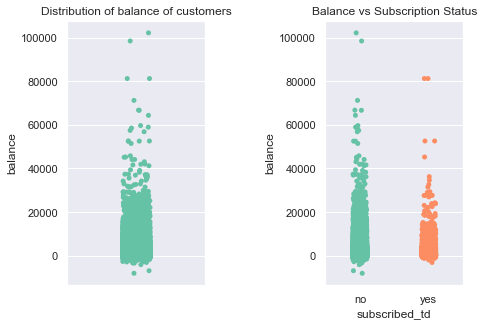

In [21]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(8,6))

sns.set_theme(style="whitegrid")
ax[0].set_title('Distribution of balance of customers')
sns.stripplot(y="balance",data=df, palette="Set2", ax=ax[0])

ax[1].set_title('Balance vs Subscription Status')
ax[1]= sns.stripplot(y="balance",x='subscribed_td',data=df, palette="Set2")

plt.tight_layout(pad=5);

The balance of the customers is visualised in the first plot and we find that more customers have their balance in the range of zero to thirty five thousand.  

In the next plot we have plotted balance against subscribtion status to check its relationship. However bank balance doesn't seem to have a significant influence on the term deposit subscription.

### Does having a loan impact customer's subscription towards Term Deposits?

Customers who are making loan installments may or may not have an inclination towards other type of savings like Term deposit. Since Term deposit is an option to save when you have excess money let's figure out if loan payers' have an affinity towards the Term Deposits.

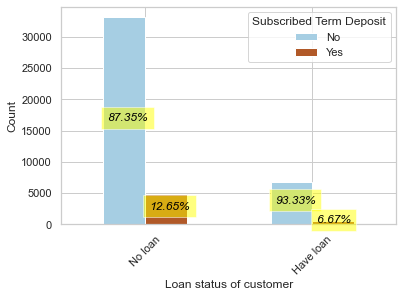

In [22]:
agg_df= df.groupby(['loan','subscribed_td']).size().reset_index()  #Grouping both job and subscribed_td
loan_agg = agg_df.groupby('loan').agg({0: lambda x:list(x)}) #Making a list of both subscribed_td states 


# Finding sum of list of each anaemic state
sum_list = []
for i in range(len(loan_agg[0])):
    sum_list.append(sum(loan_agg[0][i]))
    sum_list.append(sum(loan_agg[0][i]))
agg_df['sum']=sum_list

# Finding percentage list the agg_df
percentage_list = []
for i in range(len(agg_df[0])):
    answer = agg_df[0][i]*100/agg_df['sum'][i]
    answer = round(answer, 2)
    percentage_list.append(answer)
agg_df['percentage']=percentage_list


#Forming pivot table for plotting
df_plot = df.groupby(['loan','subscribed_td']).size().reset_index().pivot(columns='subscribed_td', 
index='loan', values=0)

#Plotting the stacked bar graph 
ax= df_plot.plot(kind='bar',  xlabel =('Loan status of customer'),ylabel=('Count'),colormap='Paired')
ax.set_xticklabels(['No loan', 'Have loan'], rotation=45);
ax.legend(title='Subscribed Term Deposit', labels=[ 'No','Yes'])

#Adding percentage to the stacked bar graph 
for i,rec in enumerate(ax.patches):
    for i in range(len(agg_df[0])):
        if rec.get_height() == agg_df[0][i]:
            ax.text(rec.get_xy()[0]+rec.get_width()/2-0.1,rec.get_xy()[1]+rec.get_height()/2,
                '{:.2%}'.format(agg_df['percentage'][i]/100), fontsize=12, color='black',style='italic',
        bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 6})
            break;

Interpreting the data in the plot:

> Among the people who have don't have loan, 87.34% have not subscribed towards Term deposits(TD) while 12.66% have.

> Among the people who have loans to pay , 93.32% have not subscribed towards Term deposits(TD) while 6.68% have.

Comparing the customers who have loan with the ones who don't have one, we can infer that 

> People who have loan are less likely to subscribe for TD as 93% have not subscribed and only 7% have TD.

> People who don't have loan are more likely to subscribe for TD as 13% have TD and 87% don't have one.

This shows that not having a loan gives customer a affinity to save using TD.

### Which type of job holders subscribed to the TD more?

In [23]:
df.job.value_counts().to_frame()

,job
blue-collar,17324
white-collar,14625
pink-collar,5393
self-employed,3064
retired,2262
unemployed,1303
student,937
unknown,288


There are eight categories of job holders among the customers. Let's find out which category of job holders have the tendency to subscribe more to the TD.  

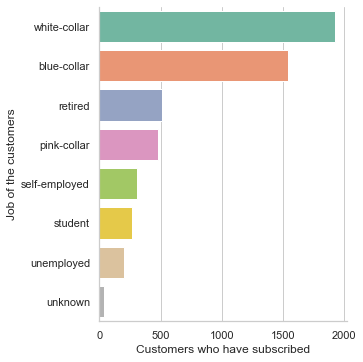

In [24]:
TD_holders_df=df[df['subscribed_td']=='yes']

ax=sns.catplot(y="job", kind="count", palette="Set2", data=TD_holders_df, order=TD_holders_df['job'].value_counts().index)
plt.xlabel("Customers who have subscribed")
plt.ylabel("Job of the customers");

#### Handling Imbalanced Data

In [25]:
output_var_df=df['subscribed_td'].value_counts().to_frame()
output_var_df.rename(columns = {'subscribed_td': 'subscribed_term_deposit'}, inplace = True)
output_var_df

,subscribed_term_deposit
no,39910
yes,5286


There clearly is a <b>class imbalance</b> as there are less people who have subscribed to the term deposit and more who haven't yet. Unless we handle it the ooutput would be biased.

Most machine learning algorithms are not very useful with biased class data. But, we can modify the current training algorithm to take into account the skewed distribution of the classes. This can be achieved by giving different weights to both the majority and minority classes. The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class.

In [26]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(df['subscribed_td']), df['subscribed_td'])
class_weights

array([0.566224  , 4.27506621])

class_weight = ‘balanced’ helps us to in giving higher weights to the minority class and lower weights to the majority class, thereby trying to make it more balanced.

Data above gives an insight on the type of job holders and their affinity towards subscribtion to TDs. Among the customers who have subscribed to the Term deposits, majority of them are white and blue collar job holders. The second set of subscribers are from the retired , pink collar jobs. 

Using this insight, bank can target the white and blue collar job holders first as they have more affinity towards subscribing to TD. Bank can target retired customers, pink collar job holders in the next phase thereby setting the priorities in the next campaign.

### Are married people more willing to take up housing loan?

<Figure size 576x360 with 0 Axes>

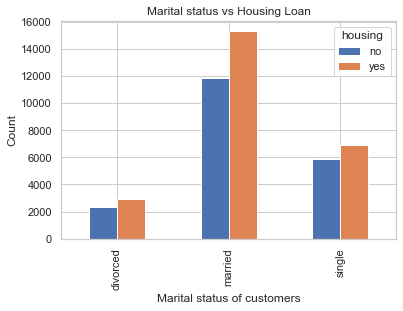

In [27]:
plt.figure(figsize=(8,5))

# Cross tabulation between marital status and housing loan
CrosstabResult=pd.crosstab(index=df['marital'],columns=df['housing'])
 
CrosstabResult.plot.bar()
plt.xlabel("Marital status of customers")
plt.ylabel("Count")
plt.title("Marital status vs Housing Loan");

From the graph it is clear that irrespective of the marital status say married, divorced or single the housing loan takers are more. There doesn't seem to be much of correlation between them.

### Subscription Status

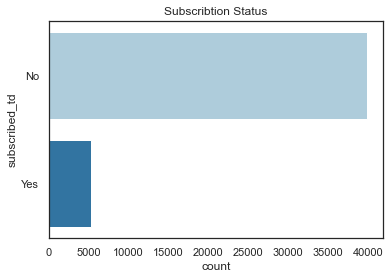

In [28]:
sns.set_style("white")
ax = sns.countplot(y="subscribed_td", data=df, orient='h', palette='Paired')
ax.set_title('Subscribtion Status')
ax.set_yticklabels(['No', 'Yes']);

In [29]:
# Count of people subscription status

output_var_df=df['subscribed_td'].value_counts().to_frame()
output_var_df.rename(columns = {'subscribed_td': 'subscribed_term_deposit'}, inplace = True)
output_var_df

,subscribed_term_deposit
no,39910
yes,5286


We have 45211 records out of which 5289 customers have subscribed and the remaining haven't. There clearly is a <b>class imbalance</b> as there are less people who have subscribed to the term deposit and more who haven't yet. Unless we handle it the ooutput would be biased.

#### Handling Imbalanced Data

Most machine learning algorithms are not very useful with biased class data. But, we can modify the current training algorithm to take into account the skewed distribution of the classes. This can be achieved by giving different weights to both the majority and minority classes. The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class.

In [30]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(df['subscribed_td']), df['subscribed_td'])
class_weights

array([0.566224  , 4.27506621])

class_weight = ‘balanced’ helps us to in giving higher weights to the minority class and lower weights to the majority class, thereby trying to make it more balanced.

In [31]:
df.head()

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed_td
1,1002,44.0,blue-collar,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,33.0,self-employed,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,1006,35.0,white-collar,married,tertiary,no,231.0,yes,no,unknown,5,may,139,1,-1,0,unknown,no


In [32]:
df.to_csv('../ML/EDAresults.csv', index=False)